In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [41]:
def weight_init(experts,opening,method,tickers):
    #add market cap initialization
    if method == 'equal':
        w = np.ones(experts)
        w[opening.iloc[0]==0] = 0
        w[opening.iloc[0].isnull()] = 0
        return w
    
    elif method == 'marketcap':
        caps_dict = pd.read_csv('marketcapdata.csv', index_col='Name').to_dict()['Market Cap']
        w = []
        
        for ticker in tickers:
            try:
                w.append(caps_dict[ticker])
            except:
                w.append(0)
        w = np.array(w)
        w[opening.iloc[0]==0] = 0
        w[opening.iloc[0].isnull()] = 0
        return np.array(w).astype('float64')
    else:
        print('Invalid method')

def losses(opening,closing,method):
    if method == 'absolute': #absolute return (close-open)
        return -1*(closing-opening)
    
    elif method=='pricerel': #price relative #closing over opening
        try:
            return -1*(closing/opening-1)
        except:
            return 0
    elif method==3: #beta
        return 1
    
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [64]:
def hedge(filename,lossmethod,weightmethod):
    #data is a T by N matrix with each row being the returns of each expert i at time t
    data = pd.read_excel(filename)[::-1]
    opening = data.iloc[:,::2]
    closing = data.iloc[:,1::2]
    #return print(opening,closing)
    tickers = [name[:name.find('_')] for name in opening.columns]
    #print(tickers)
    #return 0
    dates = opening.index.values
    #print(dates)
    #return 0
#     returns = pd.DataFrame()
#     for i in range(len(opening.columns)):
#         tick = closing.iloc[:,i].name[:4]
#         returns[tick]=closing.iloc[:,i]-opening.iloc[:,i]
    
#     pricerel = pd.DataFrame()
#     for i in range(len(opening.columns)):
#         tick = closing.iloc[:,i].name[:4]
#         pricerel[tick]=closing.iloc[:,i]/opening.iloc[:,i]
    
    T = len(data)
    N = len(opening.columns)
    epsilon = np.sqrt(np.log(N)/T) 
   
    w = weight_init(N,opening,weightmethod, tickers)
    p = w/sum(w)
    start = 10000000
    #start_open = opening.iloc[0].values
    #return start_open
    #start_quant = []
    #for j,k in enumerate(start_open):
        #print(p[j]*start)
     #   if k == 0:
            #start_quant.append(0)
      #  elif p[j] != 0:
            #start_quant.append((p[j]*start)/k)
       # else:
        #    start_quant.append(0)
    #print(start_quant*start_open)

    quantities = [] #$/prices = quantity of each
    #return quantities

    probs = [p]
    values =[]
    transaction = []
    
    start_time = 1 if (lossmethod=='pricerel') else 0
    if start_time == 1:
        values.append(start)
        
    for t in range(start_time,T):
        #find new prices for the day
        #opening_prices_na = opening.iloc[t]
        #closing_prices_na = closing.iloc[t]
        if lossmethod=='absolute':
            opening_prices = opening.iloc[t].values
            opening_prices[opening.iloc[t].isnull()] = 0
            closing_prices = closing.iloc[t].values
            closing_prices[closing.iloc[t].isnull()] = 0
        elif lossmethod=='pricerel':
            opening_prices = opening.iloc[t-1].values
            opening_prices[opening.iloc[t-1].isnull()] = 0
            closing_prices = opening.iloc[t].values
            closing_prices[opening.iloc[t].isnull()] = 0
            
        if 0 not in opening_prices and weightmethod=='equal' and 0 in w:
            w[w==0] = 1
        elif 0 not in opening_prices and weightmethod=='marketcap' and 0 in w:
            caps_dict = pd.read_csv('marketcapdata.csv', index_col='Name').to_dict()['Market Cap']
            wt = []
            for ticker in np.array(tickers)[w==0]:
                try:
                    wt.append(caps_dict[ticker])
                except:
                    wt.append(0)
            w[w==0] = wt
#             print(w)
#             return 0
        #print(opening_prices,closing_prices)
    
        #return opening_prices
        
        #portfolio value
        if t==start_time: 
            values.append(start)
        else:
            values.append(np.sum(np.array(opening_prices)*np.array(quantities[t-start_time-1]))) #new opening value
        #print(t)
        #print(values[t])
        
        q_t = []
        for j,k in enumerate(opening_prices):
            if k == 0:
                q_t.append(0)
            elif p[j] != 0:
                try:
                    q_t.append((p[j]*values[t])/k)
                except:
                    q_t.append(0)
            else:
                q_t.append(0)
        quantities.append(q_t)
        #print(q_t)
        loss = losses(opening_prices,closing_prices,lossmethod)
        #print(loss)
        loss[np.isnan(loss)] = 0
        M = max(abs(loss))
        try:
            loss = losses(opening_prices,closing_prices,lossmethod)/M
        except:
            loss = losses(opening_prices,closing_prices,lossmethod)
        loss[np.isnan(loss)] = 0
        
        #return loss
                
        #check sum of weight updates
        #money_moved = sum(np.absolute([-p[i]*epsilon*loss[i] for i in range(N)]))*values[t]
        money_moved = sum(np.absolute([p[i]*(np.exp(-1*epsilon*float(loss[i]))-1) for i in range(N)]))*values[t]
        
        if t==start_time or values[t]-values[t-1] >= 0.015*money_moved:
            for i in range(N):
                w[i] = w[i]*(np.exp(-1*epsilon*float(loss[i])))
            transaction.append((t,0.015*money_moved))
        #print(w,transaction)
        #print(money_moved)
       
        p = w/sum(np.absolute(w))

        probs.append(p)
        
        #return p
#         if t>=T-3:
#             print(opening_prices, closing_prices)
#             print(q_t, values[t])
#             print(loss)
#             print(money_moved)
#             print(w,p)
    
    out = pd.DataFrame(probs[1-start_time:],columns=tickers,index=dates)
    #return transaction
    #print(out)
    out['Values'] = values
    out.to_csv(f'hedge_weights_return_{weightmethod}_{lossmethod}_{filename[:-5]}.csv')
    print('Final distribution: ',p)
    print('Final transaction %: ',len(transaction)/T*100,'total cost: ',sum([v[1] for v in transaction]))
    print('starting value: ',start,'final value: ',values[-1],'less transaction costs: ',values[-1]-sum([v[1] for v in transaction]))
    #np.savetxt('q_lv_w.csv',quantities,delimiter=',')
    print('Return',((values[-1]-sum([v[1] for v in transaction]))-start)/start*100,'%')
    plt.plot(values)
    plt.show()
#     return values

In [95]:
filename = 'highvol_daily.xlsx'

Final distribution:  [0.01869017 0.02243383 0.50064006 0.02647528 0.02934811 0.01676792
 0.01393581 0.01646948 0.02352083 0.1745858  0.01868439 0.02035271
 0.01944053 0.02118055 0.02138601 0.01356131 0.02041837 0.02210884]
Final transaction %:  53.45786963434023 total cost:  8820213.349583894
starting value:  10000000 final value:  94182847.69792399 less transaction costs:  85362634.3483401
Return 753.626343483401 %


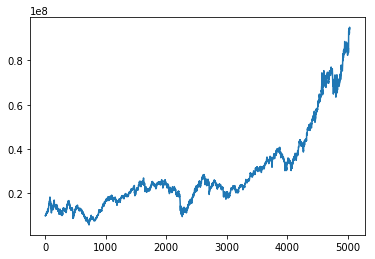

In [96]:
hedge(filename,'absolute','equal')

Final distribution:  [3.06769514e-04 9.80986259e-01 1.31322331e-02 1.20411204e-04
 5.48144870e-05 8.80520524e-04 1.00171567e-04 1.48172616e-04
 4.21176013e-05 9.00720744e-04 1.61414559e-04 5.76881350e-04
 2.58548716e-05 1.74836878e-03 3.42824602e-04 4.37857373e-05
 1.28136458e-04 3.00542910e-04]
Final transaction %:  50.87440381558028 total cost:  6361932.47891444
starting value:  10000000 final value:  20418060.981846184 less transaction costs:  14056128.502931744
Return 40.56128502931744 %


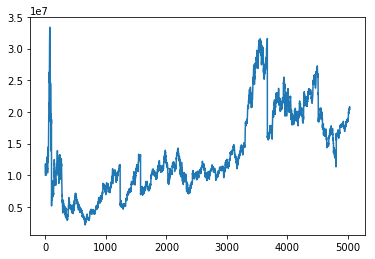

In [97]:
hedge(filename,'absolute','marketcap')

Final distribution:  [0.0505677  0.04645512 0.11957217 0.07434273 0.05262265 0.04777683
 0.01887784 0.14596477 0.04255298 0.15197921 0.02998921 0.03175368
 0.03146518 0.03333916 0.03390773 0.02756967 0.02795679 0.03330657]
Final transaction %:  52.58346581875993 total cost:  8708203.63879172
starting value:  10000000 final value:  57574246.9401648 less transaction costs:  48866043.30137308
Return 388.66043301373077 %


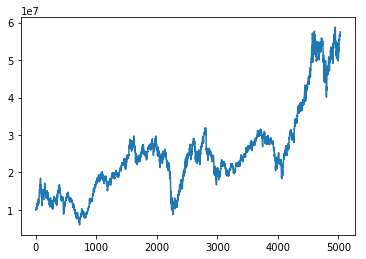

In [98]:
hedge(filename,'pricerel','equal')

Final distribution:  [1.56530435e-04 9.94882304e-01 1.54776809e-03 1.57556894e-04
 3.50694241e-05 6.27159051e-04 8.03286113e-05 1.72082011e-04
 1.72456190e-05 3.47785376e-04 9.88345683e-05 3.43022900e-04
 1.52596358e-05 1.05929310e-03 1.97862706e-04 3.00999515e-05
 6.94206990e-05 1.62376669e-04]
Final transaction %:  50.91414944356121 total cost:  4063767.2643109593
starting value:  10000000 final value:  20289785.127877254 less transaction costs:  16226017.863566294
Return 62.260178635662946 %


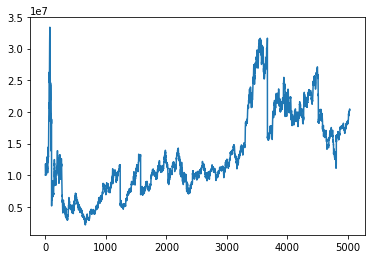

In [99]:
hedge(filename,'pricerel','marketcap')